In [1]:
import matplotlib.pyplot as plt
from fenics import *
from scipy.signal import correlate2d
from scipy.ndimage import gaussian_filter
from mshr import *
import numpy as np
from dotenv import load_dotenv
import os
from scipy.stats import linregress
from scipy.interpolate import interp1d
set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
nueva_ruta = '/media/erick/TOSHIBA EXT/tests'

In [3]:
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = 1


# Define mesh and space
nodes_in_xaxis=int(os.getenv('nodes_in_xaxis'))
nodes_in_yaxis=int(os.getenv('nodes_in_yaxis'))
space_size=int(os.getenv('space_size'))

os.chdir(nueva_ruta)

In [4]:
def calculate_correlation(field1, field2, field1_name, field2_name, step, nodes_in_xaxis, nodes_in_yaxis, space_size, sigma=1):
    """
    Calcula la correlación cruzada normalizada entre dos campos 2D considerando la malla espacial,
    asegurando que la correlación esté correctamente normalizada en el rango [-1,1].
    Aplica un suavizado con un filtro gaussiano para reducir ruido en la visualización.
    """

    # Calcular media y desviación estándar de cada campo
    mean1, std1 = np.mean(field1), np.std(field1)
    mean2, std2 = np.mean(field2), np.std(field2)

    print(f'Correlación de {field1_name} con {field2_name} al tiempo {step} considerando la malla espacial.')

    # Evitar divisiones por cero
    if std1 == 0 or std2 == 0:
        print("Advertencia: Desviación estándar cero detectada. Devolviendo matriz de ceros.")
        correlation = np.zeros((2 * field1.shape[0] - 1, 2 * field1.shape[1] - 1))
        return correlation

    # Normalizar los campos
    field1 = (field1 - mean1) / std1
    field2 = (field2 - mean2) / std2

    # Dimensiones de los campos
    rows, cols = field1.shape
    max_shift = rows - 1

    # Definir la resolución espacial
    dx = space_size / nodes_in_xaxis
    dy = space_size / nodes_in_yaxis

    # Inicializar matriz para almacenar la correlación cruzada
    correlation = np.zeros((2 * rows - 1, 2 * cols - 1))
    
    # Crear matrices de coordenadas espaciales con la escala correcta
    x_positions = np.linspace(-space_size / 2, space_size / 2, correlation.shape[1])
    y_positions = np.linspace(-space_size / 2, space_size / 2, correlation.shape[0])

    # Calcular la correlación cruzada normalizada
    for i in range(-max_shift, max_shift + 1):
        for j in range(-max_shift, max_shift + 1):
            overlap1 = field1[max(0, i):rows + min(0, i), max(0, j):cols + min(0, j)]
            overlap2 = field2[max(0, -i):rows + min(0, -i), max(0, -j):cols + min(0, -j)]
            if overlap1.size > 0:
                C_xy = np.mean(overlap1 * overlap2)
                correlation[i + max_shift, j + max_shift] = np.clip(C_xy, -1, 1)  # Asegurar normalización

    # Aplicar suavizado con filtro gaussiano
    correlation_smoothed = gaussian_filter(correlation, sigma=sigma)

    # Guardar la matriz de correlación en un archivo
    f_save = f"correlacion_{field1_name}_{field2_name}_{step:.3f}.txt"
    np.savetxt(f_save, correlation_smoothed, delimiter="\t")

    print(f'Correlación suavizada de {field1_name} con {field2_name} al tiempo {step} guardada en {f_save}')

    # Graficar la correlación en unidades físicas
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_smoothed, extent=[x_positions[0], x_positions[-1], y_positions[0], y_positions[-1]], 
               origin='lower', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(label="Correlación Normalizada (Suavizada)")
    plt.xlabel("Desplazamiento en X (unidades físicas)")
    plt.ylabel("Desplazamiento en Y (unidades físicas)")
    plt.title(f"Correlación Suavizada de {field1_name} con {field2_name} (Tiempo {step})")
    plt.show()

    return correlation_smoothed

In [7]:
def load_field(field1_name, field2_name, step, nb):
    """
    Procesa campos guardados por field_to_numpy_array y calcula correlaciones.

    Args:
        field_name1 (str): Nombre del primer campo (e.g., "c").
        field_name2 (str): Nombre del segundo campo (e.g., "s").
        step (str): Paso de tiempo formateado (e.g., "0.000").
        nb (int): Bloque a procesar.

    Returns:
        dict: Correlación cruzada entre los dos campos.
    """
    file1 = f"matrix_{field1_name}_{step:.3f}_nb_{nb}.txt"
    file2 = f"matrix_{field2_name}_{step:.3f}_nb_{nb}.txt"

    # Cargar los campos
    field1 = np.loadtxt(file1, delimiter="\t")
    field2 = np.loadtxt(file2, delimiter="\t") 

    return field1, field2

In [8]:
def compute_correlation_length(correlation, nodes_in_xaxis, space_size):
    """
    Calcula la longitud de correlación en el eje X basado en la matriz de correlación cruzada.
    Se define como la distancia en la que la correlación cae por debajo de e^{-1}.
    """
    # Parámetros de la malla
    dx = space_size / nodes_in_xaxis  # Espaciado en x

    # Centro de la matriz de correlación
    center = correlation.shape[0] // 2

    # Extraer la fila central (correlación a lo largo del eje x)
    correlation_x = correlation[center, :]

    # Crear vector de posiciones en el eje X con la escala correcta
    x_positions = np.linspace(-space_size / 2, space_size / 2, len(correlation_x))

    # Buscar la longitud de correlación donde cae por debajo de e^{-1}
    threshold = np.exp(-1)
    correlation_x_abs = np.abs(correlation_x)  # Considerar valores absolutos
    idx = np.where(correlation_x_abs < threshold)[0]

    if len(idx) > 0:
        correlation_length_x = np.abs(x_positions[idx[0]])
    else:
        correlation_length_x = np.max(np.abs(x_positions))  # Si no cae, tomamos el máximo

    # Graficar la correlación
    plt.figure(figsize=(8, 5))
    plt.plot(x_positions, correlation_x, label="Correlación en X")
    plt.axhline(y=threshold, color='r', linestyle='--', label="e^{-1} Umbral")
    plt.axvline(x=correlation_length_x, color='g', linestyle='--', label=f"Longitud de Correlación ≈ {correlation_length_x:.2f}")
    plt.xlabel("Distancia en X (unidades físicas)")
    plt.ylabel("Correlación Normalizada")
    plt.title("Longitud de Correlación en el Eje X")
    plt.legend()
    plt.grid()
    plt.show()

    return correlation_length_x


In [9]:
# Parámetros de entrada
field1_name = "c"  # Campo c (cáncer)
field2_name = "s"  # Campo s (células sanas)

Correlación de c con s al tiempo 0 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0 guardada en correlacion_c_s_0.000.txt


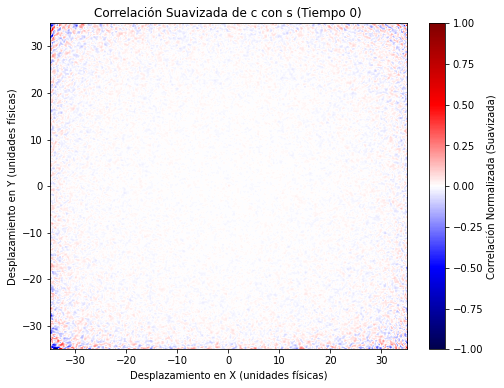

Correlación de c con s al tiempo 0.005 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.005 guardada en correlacion_c_s_0.005.txt


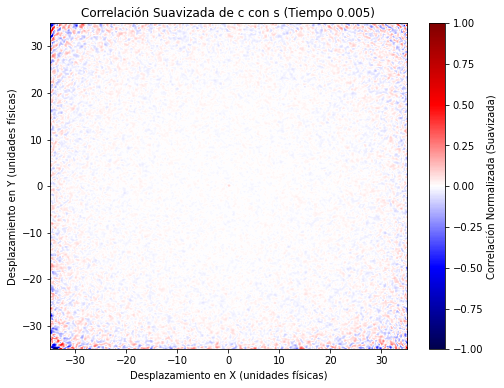

Correlación de c con s al tiempo 0.01 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.01 guardada en correlacion_c_s_0.010.txt


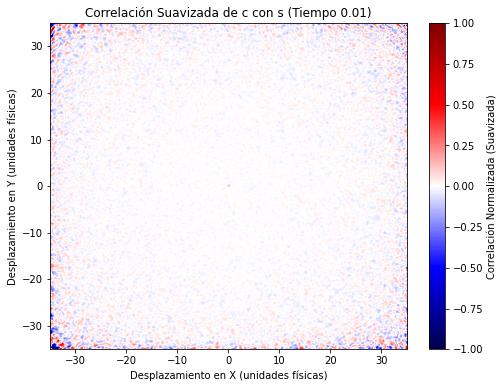

Correlación de c con s al tiempo 0.015 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.015 guardada en correlacion_c_s_0.015.txt


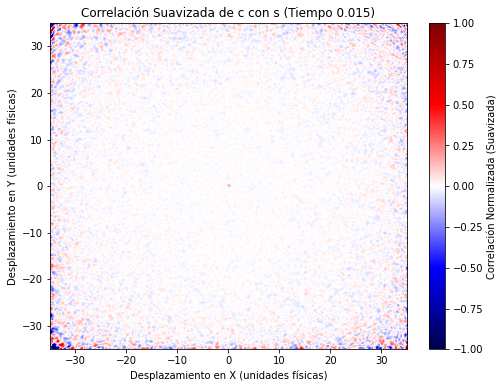

Correlación de c con s al tiempo 0.02 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.02 guardada en correlacion_c_s_0.020.txt


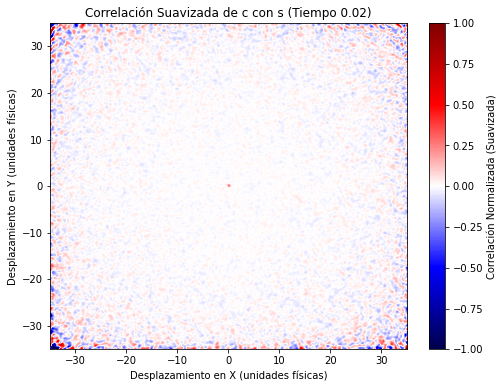

Correlación de c con s al tiempo 0.025 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.025 guardada en correlacion_c_s_0.025.txt


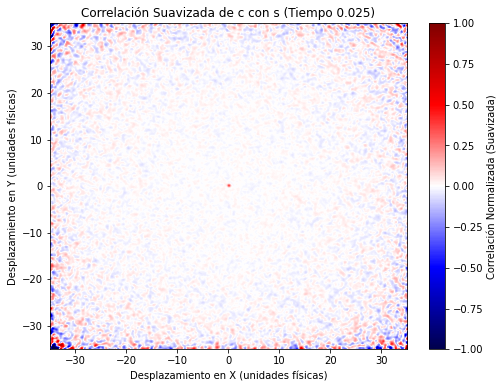

Correlación de c con s al tiempo 0.030000000000000002 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.030000000000000002 guardada en correlacion_c_s_0.030.txt


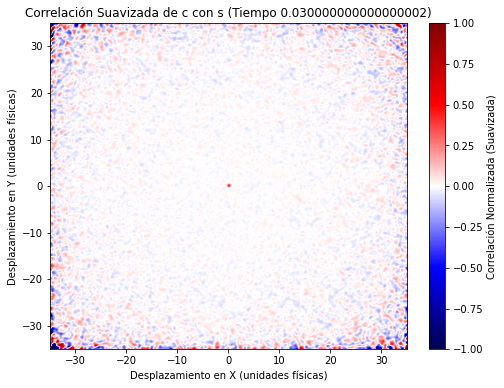

Correlación de c con s al tiempo 0.035 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.035 guardada en correlacion_c_s_0.035.txt


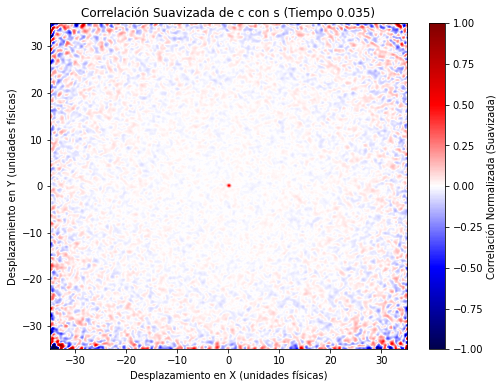

Correlación de c con s al tiempo 0.04 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.04 guardada en correlacion_c_s_0.040.txt


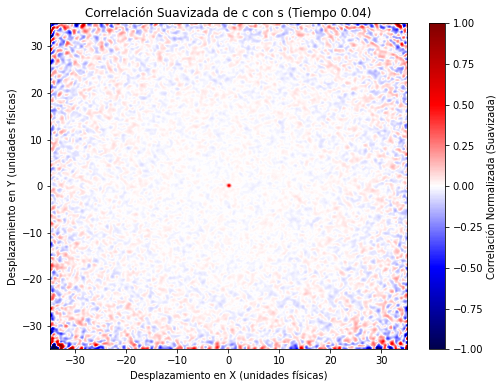

Correlación de c con s al tiempo 0.045 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.045 guardada en correlacion_c_s_0.045.txt


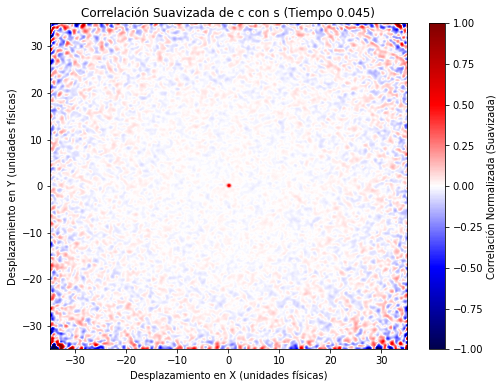

Correlación de c con s al tiempo 0.049999999999999996 considerando la malla espacial.
Correlación suavizada de c con s al tiempo 0.049999999999999996 guardada en correlacion_c_s_0.050.txt


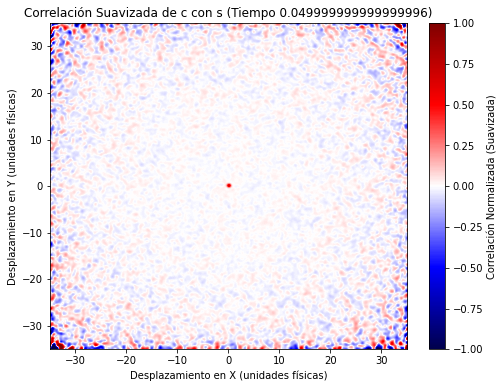

Correlación de c con s al tiempo 0.05499999999999999 considerando la malla espacial.


In [ ]:
t = 0
while t <= T:
    # Cargar campos
    field1, field2 = load_field(field1_name, field2_name, t, nb)
    calculate_correlation(field1, field2, field1_name, field2_name, t, nodes_in_xaxis, nodes_in_yaxis, space_size)
    t += dt

In [ ]:
t = 0
length_corr = []
while t <= T:
    print(t)
    file1 = f'correlacion_{field1_name}{field2_name}_{t:.3f}.txt'
    corr = np.loadtxt(file1, delimiter="\t")
    corr = np.fft.fftshift(corr)


#     # Escalar los valores para mantener la estructura de la matriz
#     corr = corr / np.abs(np.min(corr)) if np.min(corr) != 0 else corr

    # Graficar
    print('Correlación')
    plt.figure(figsize=(6, 5))
    plt.imshow(corr, cmap='viridis', origin='lower')
    plt.colorbar(label='Log Magnitude')
    plt.title(f'Correlación ({field1_name} vs {field2_name}) Fourier')
    plt.xlabel('Frecuencia X')
    plt.ylabel('Frecuencia Y')
    plt.show()

    compute_correlation_length(corr, nodes_in_xaxis, space_size)
    
    # corr_function = directional_correlation_function(corr, nodes_in_xaxis, nodes_in_yaxis, space_size)
    # correlation_length = compute_correlation_length(corr_function, nodes_in_xaxis, nodes_in_yaxis, space_size)
    # print('Correlación', correlation_length)

    
    # unique_distances, radial_means, correlation_length = radial_correlation_function(corr, field1_name, field2_name, t, title="Curva del promedio radial")
    # plot_correlation(corr, field1_name, field2_name, t)
    # length_corr.append([t, correlation_length])
    
    t += dt

In [ ]:
length_corr = np.array(length_corr)
np.savetxt(
    f'corr_length_time_{field1_name}_{field2_name}.txt',   # Nombre del archivo
    length_corr,                # Array a guardar
    fmt="%.2f",                # Formato de los valores (dos decimales)
    delimiter="\t",            # Separador (tabulación en este caso)
    header="Col1\tCol2"        # Encabezados de las columnas
)